In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Wczytanie danych
df = pd.read_csv('./data/car_price_prediction.csv')
df.columns = [col.strip().replace(' ', '_').replace('.', '').lower() for col in df.columns]


In [43]:
# Mapowanie zmiennych
df['leather_interior'] = df['leather_interior'].map({'Yes': 1, 'No': 0})
df['engine_volume'] = df['engine_volume'].astype(str).str.replace(' Turbo', '', regex=False).astype(float)
df['mileage'] = df['mileage'].astype(str).str.replace(' km', '', regex=False).str.replace(',', '').astype(int)
door_mapping = {
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '02-Mar': 2,
    '04-May': 4,
    'Other': 5,
    '>5': 5
}

df['doors'] = df['doors'].astype(str).map(door_mapping).fillna(5).astype(int)
df['levy'] = pd.to_numeric(df['levy'], errors='coerce').fillna(0)

# Usunięcie outlierów w price
df = df[df['price'] < df['price'].quantile(0.99)]

# Kategoryczne na one-hot
categorical = ['manufacturer', 'model', 'category', 'fuel_type', 'gear_box_type', 'drive_wheels', 'wheel', 'color']
df = pd.get_dummies(df, columns=categorical, drop_first=True)

# Usunięcie ID
df.drop(['id'], axis=1, inplace=True)


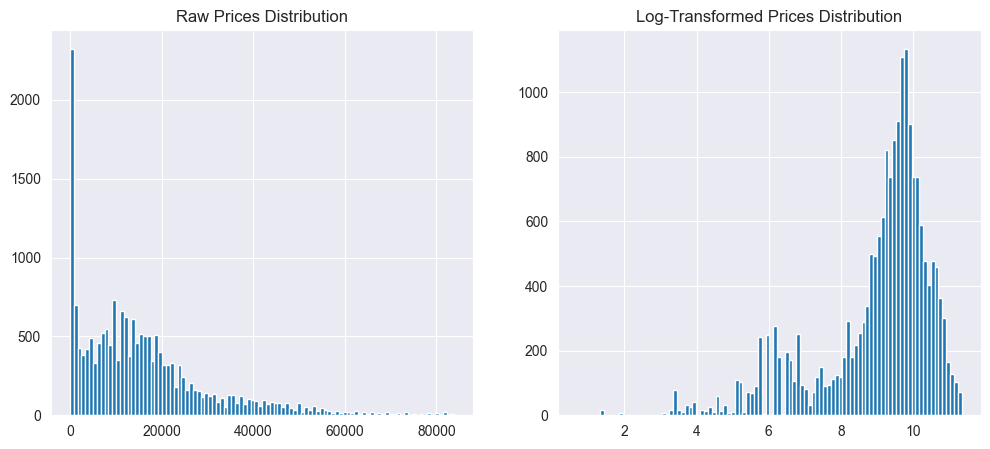

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=100)
plt.title("Raw Prices Distribution")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df['price']), bins=100)
plt.title("Log-Transformed Prices Distribution")
plt.show()


In [45]:
X = df.drop('price', axis=1)
y = np.log1p(df['price'])  # Logarytmiczna transformacja celu

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [73]:


from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()


C:\Users\Belucha\PycharmProjects\eksploracja\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 128)            │       211,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,161 (860.00 KB)

 Trainable params: 220,161 (860.00 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    # callbacks=[early_stop, reduce_lr],
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5726 - val_loss: 3.8204
Epoch 2/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5907 - val_loss: 2.7552
Epoch 3/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3477 - val_loss: 2.7546
Epoch 4/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2089 - val_loss: 2.9215
Epoch 5/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0184 - val_loss: 2.6805
Epoch 6/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9555 - val_loss: 2.5176
Epoch 7/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8178 - val_loss: 2.5236
Epoch 8/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7316 - val_loss: 2.5248
Epoch 9/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6689 - val_loss: 2.2303
Epoch 10/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6054 - val_loss: 2.2202
Epoch 11/200
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5658 - val_loss: 1.8368
Epoch 12/200
191/191 ━━━━━━━━━━━━━━━━━━━━

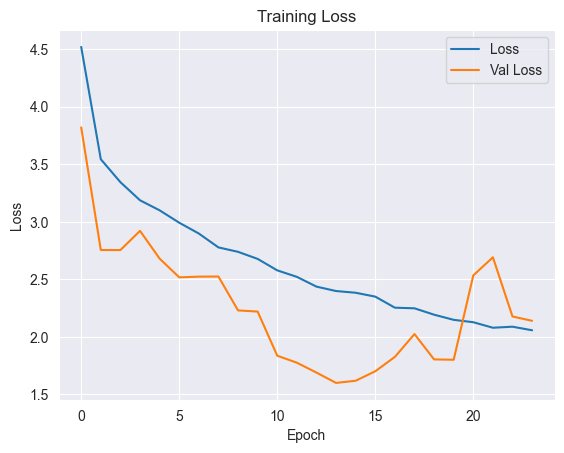

In [80]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [82]:
# Predykcja i odwrotność log1p
y_pred = model.predict(X_test_scaled).flatten()
y_pred = np.expm1(y_pred)
y_true = np.expm1(y_test)

# Metryki
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
RMSE: 13156.32
MAE: 8094.49


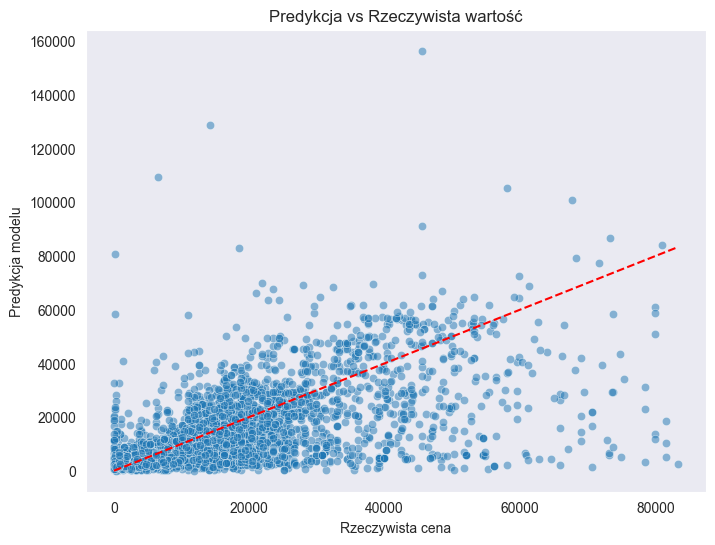

In [83]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Rzeczywista cena")
plt.ylabel("Predykcja modelu")
plt.title("Predykcja vs Rzeczywista wartość")
plt.grid()
plt.show()

In [84]:
from sklearn.metrics import r2_score

r2 = r2_score(y_true, y_pred)
print(f'R²: {r2:.4f}')

R²: 0.2127


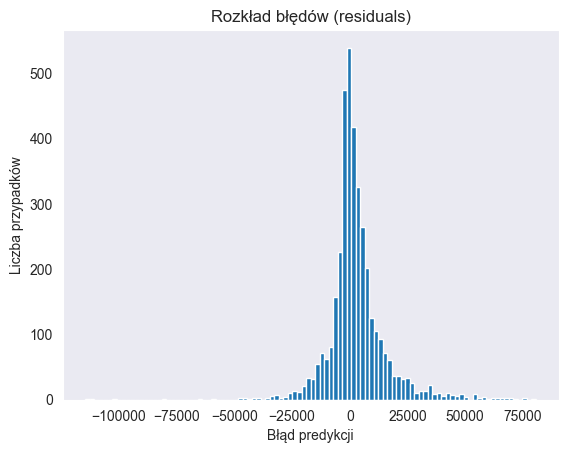

In [85]:
residuals = y_true - y_pred
plt.hist(residuals, bins=100)
plt.title("Rozkład błędów (residuals)")
plt.xlabel("Błąd predykcji")
plt.ylabel("Liczba przypadków")
plt.grid()
plt.show()

In [86]:
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 349.28%
